<a href="https://colab.research.google.com/github/sokrypton/af_backprop/blob/beta/examples/AlphaFold_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold Single
(For DEMO purposes only, run AlphaFold with single-sequence input)

In [32]:
#@title Setup
from IPython.utils import io
import os,sys
import tensorflow as tf
import jax
import jax.numpy as jnp
import re

with io.capture_output() as captured:
  if not os.path.isdir("af_backprop"):
    %shell git clone -b beta https://github.com/sokrypton/af_backprop.git
    %shell pip -q install biopython dm-haiku ml-collections py3Dmol
    %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
  if not os.path.isdir("params"):
    %shell mkdir params
    %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('/content/af_backprop')
from utils import *

# import libraries
import colabfold as cf
from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.model import data, config, model
from alphafold.common import residue_constants

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def setup_model(max_len, model_name="model_5_ptm"):

  clear_mem()

  # setup model
  cfg = config.model_config(model_name)
  cfg.model.num_recycle = 0
  cfg.data.common.num_recycle = 0
  cfg.data.eval.max_msa_clusters = 1
  cfg.data.common.max_extra_msa = 1
  cfg.data.eval.masked_msa_replace_fraction = 0
  cfg.model.global_config.subbatch_size = None
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(cfg, model_params, is_training=False)

  seq = "A" * max_len
  length = len(seq)
  feature_dict = {
      **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
      **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
  }
  inputs = model_runner.process_features(feature_dict,random_seed=0)

  def runner(seq, opt):
    # update sequence
    inputs = opt["inputs"]
    inputs.update(opt["prev"])
    update_seq(seq, inputs)
    update_aatype(inputs["target_feat"][...,1:], inputs)

    # mask prediction
    mask = seq.sum(-1)
    inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
    inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
    inputs["residue_index"] = jnp.where(mask==1,inputs["residue_index"],0)

    # get prediction
    key = jax.random.PRNGKey(0)
    outputs = model_runner.apply(opt["params"], key, inputs)

    prev = {"init_msa_first_row":outputs['representations']['msa_first_row'][None],
            "init_pair":outputs['representations']['pair'][None],
            "init_pos":outputs['structure_module']['final_atom_positions'][None]}
    
    aux = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
          "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
          "plddt":get_plddt(outputs),"pae":get_pae(outputs),
          "inputs":inputs, "prev":prev}
    return aux

  return jax.jit(runner), {"inputs":inputs,"params":model_params}

MAX_LEN = 50
RUNNER, OPT = setup_model(MAX_LEN)

Running on GPU


In [33]:
%%time
#@title Enter the amino acid sequence to fold ⬇️

sequence = 'MQDGPGTLDVFVAAGWNTDNTIEITGGATYQLSPYIMVKAGYGWNNSSLNRFEFGGGLQYKVTPDLEPYAWAGATYNTDNTLVPAAGAGFRYKVSPEVKLVVEYGWNNSSLQFLQAGLSYRIQP' #@param {type:"string"}
recycles = 24 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
SEQ = re.sub("[^A-Z]", "", sequence.upper())
LEN = len(sequence)
if LEN > MAX_LEN:
  print("recompiling...")
  MAX_LEN = LEN
  RUNNER, OPT = setup_model(MAX_LEN)

x = np.array([residue_constants.restype_order.get(aa,-1) for aa in SEQ])
x = np.pad(x,[0,MAX_LEN-LEN],constant_values=-1)
x = jax.nn.one_hot(x,20)

OPT["prev"] = {'init_msa_first_row': np.zeros([1, MAX_LEN, 256]),
               'init_pair': np.zeros([1, MAX_LEN, MAX_LEN, 128]),
               'init_pos': np.zeros([1, MAX_LEN, 37, 3])}

for r in range(recycles+1):
  outs = RUNNER(x, OPT)
  OPT["prev"] = outs["prev"]
  print(r, outs["plddt"][:LEN].mean())
outs = jax.tree_map(lambda x:np.asarray(x), outs)

recompiling...
0 0.35147363
1 0.38457075
2 0.4256418
3 0.46486163
4 0.484821
5 0.5018173
6 0.5140882
7 0.52464193
8 0.532958
9 0.53988975
10 0.5453342
11 0.54958206
12 0.55288243
13 0.55580324
14 0.5588036
15 0.5607099
16 0.5622546
17 0.5626718
18 0.5622617
19 0.56118906
20 0.5596232
21 0.55791014
22 0.55641824
23 0.5550239
24 0.5535397
CPU times: user 19.1 s, sys: 5.18 s, total: 24.3 s
Wall time: 22.8 s


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

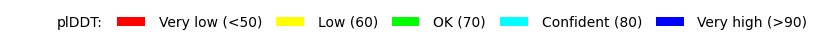

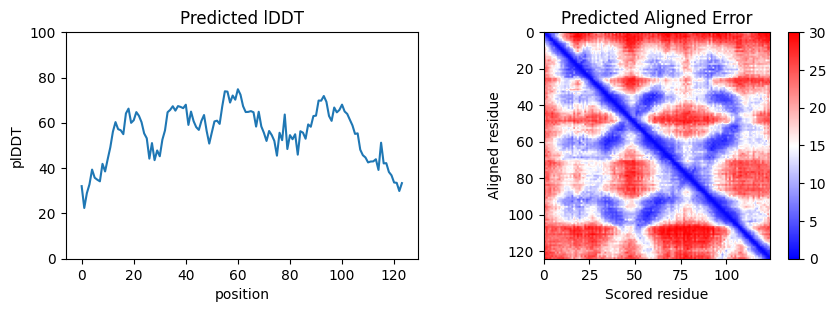

In [34]:
#@title Display 3D structure {run: "auto"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def save_pdb(outs, filename):
  '''save pdb coordinates'''
  p = {"residue_index":outs["inputs"]["residue_index"][0][:LEN],
        "aatype":outs["inputs"]["aatype"].argmax(-1)[0][:LEN],
        "atom_positions":outs["final_atom_positions"][:LEN],
        "atom_mask":outs["final_atom_mask"][:LEN]}
  b_factors = 100.0 * outs["plddt"][:LEN,None] * p["atom_mask"]
  p = protein.Protein(**p,b_factors=b_factors)
  pdb_lines = protein.to_pdb(p)
  with open(filename, 'w') as f:
    f.write(pdb_lines)

save_pdb(outs,"out.pdb")
num_res = int(outs["inputs"]["aatype"][0].sum())

cf.show_pdb("out.pdb", show_sidechains, show_mainchains, color,
            color_HP=True, size=(800,480)).show()
if color == "lDDT":
  cf.plot_plddt_legend().show()  
if "pae" in outs:
  cf.plot_confidence(outs["plddt"][:LEN]*100, outs["pae"][:LEN,:LEN]).show()
else:
  cf.plot_confidence(outs["plddt"][:LEN]*100).show()